<a href="https://colab.research.google.com/github/yuukimotai/GA4_QABot/blob/main/GA4_QA_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ファインチューニング前応答確認

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install datasets

In [ ]:
!pip3 install fugashi ipadic

In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer# QAモデルとBertの日本語トークナイザ
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴は何がありますか？"
model_name = "cl-tohoku/bert-base-japanese"#東北大事前学習モデルV1
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴は何がありますか？

A:  大 規模 な 広告 主 や 広告


In [ ]:
!pip3 install unidic_lite

In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴は何ですか？"
model_name = "cl-tohoku/bert-base-japanese-v2"#東北大事前学習モデルV2
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴は何ですか？

A:  


In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴って何ですか？"
model_name = "cl-tohoku/bert-base-japanese-v3"#東北大事前学習モデルV3
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴って何ですか？

A:  [CLS] アナリティクス 360 の 特徴 って 何 です か ? [SEP] アナリティクス 360 で 企業 向け 機能 を 利用 する アナリティクス 360 は Google アナ リティクス 4 プロパティ を 基盤 と


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer#QAモデルとトークナイザの自動検出

question = 'アナリティクス360の特徴は何がありますか？'
context = 'アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。'

model = AutoModelForQuestionAnswering.from_pretrained(
    'SkelterLabsInc/bert-base-japanese-jaquad')
tokenizer = AutoTokenizer.from_pretrained(
    'SkelterLabsInc/bert-base-japanese-jaquad')

inputs = tokenizer(
    question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)

answer_end = torch.argmax(answer_end_scores) + 1

answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Q:  アナリティクス360の特徴は何がありますか？

A:  企業 向け 機能 を 利用 する アナリティクス 360 は Google アナリティクス 4 プロパティ を


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

question = 'アナリティクス360の特徴は何がありますか？'
context = 'アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。'
model_name = base_path + "yuukimotai_roberta-finetuned-squad_20240815/checkpoint-2650"#8/15の間にファインチューニングできたチェックポイント読み込み
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

inputs = tokenizer(
    question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)

answer_end = torch.argmax(answer_end_scores) + 1

answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Q:  アナリティクス360の特徴は何がありますか？

A:  カスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズ


### ファインチューニング用区画

In [ ]:
path = "/content/drive/MyDrive/nlp_dataset/parsed_texts/" #GA4関連のHTMLパースしたテキスト

In [ ]:
base_path = "/content/drive/MyDrive/nlp_dataset/models/" #ファインチューニングできたモデル

In [ ]:
squad_path = "/content/drive/MyDrive/nlp_dataset/ga4_squad/"

In [ ]:
import re# html パース用

with open(base_path + 'ga4_info-measurement.txt', 'r') as f:
  before_parse = f.read()
parsed_text =  re.sub(re.compile('<.*?>'), '', before_parse)
with open(path + 'ga4_parsed_info-measurement.txt', 'w') as f:
  f.writelines(parsed_text)

In [ ]:
with open(path + 'ga4_parsed_web-app.txt', 'r') as f:
  parsed_texts = f.read()
  parsed_texts = parsed_texts.replace('\n', "。")
parsed_texts

In [ ]:
import json# SQuADデータ作成用セル

with open(squad_path + "web-app.json", "w", encoding='utf-8') as f:
    data = {
        "data": [
            {
              "title": "",
              "paragraphs": [
                                {
                                    "context": parsed_texts,
                                    "qas": [
                                                {
                                                    "id": "",
                                                    "question": "",
                                                    "answers": [
                                                                    {
                                                                        "text": "",
                                                                        "answer_start": []
                                                                    }
                                                                ]
                                                }
                                           ]
                                }
                            ]
            }
        ]
    }
    json.dump(data, f, indent=4, ensure_ascii=False)

In [ ]:
import json
with open(squad_path + "web-app.json", "r") as f:
  data = json.load(f)
data

In [ ]:
with open(path + 'ga4_parsed_web-app.txt', 'w') as f:
  for sentence in parsed_texts:
    sentence = sentence.replace('。', '\n')
    if sentence != "":
      f.writelines(sentence)

In [ ]:
import json

json_list = []
with open(squad_path + "business-accountsettings.json", "a", encoding='utf-8') as f:
  for i in range(len(parsed_texts)):# parseしたテキストの行数だけループ
      data = {
          "context": parsed_texts[i],
          "question": "",
          "answers": {
              "text": [],
              "answer_start": []
          }
      }
      json_list.append(data)
  json.dump(json_list, f, indent=4, ensure_ascii=False)# json_listに入れたデータを出力

In [ ]:
import json

json_list = []
with open(squad_path + "business-accountsettings_v2.json", "w", encoding='utf-8') as f:
  for i in range(len(parsed_texts)):
    data = {
        "data": [
            {
              "title": "",
              "paragraphs": [
                                {
                                    "context": parsed_texts[i],
                                    "qas": [
                                                {
                                                    "id": "",
                                                    "question": "",
                                                    "answers": [
                                                                    {
                                                                        "text": "",
                                                                        "answer_start": []
                                                                    }
                                                                ]
                                                }
                                           ]
                                }
                            ]
            }
        ]
    }
    json_list.append(data)
  json.dump(json_list, f, indent=4, ensure_ascii=False)

In [ ]:
with open(path + 'ga4_parsed_analytics360.txt', 'w') as f:
  for sentence in sentence_list:
    f.writelines(sentence)

In [ ]:
!pip3 install fugashi ipadic

In [ ]:
!pip3 install datasets

In [ ]:
!pip3 show datasets

In [ ]:
from datasets import load_dataset
squad = load_dataset('SkelterLabsInc/JaQuAD', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/31748 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3939 [00:00<?, ? examples/s]

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'question_type', 'answers'],
        num_rows: 31748
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'question_type', 'answers'],
        num_rows: 3939
    })
})

In [ ]:
from datasets import load_dataset
import pandas as pd

squad = load_dataset('facebook/belebele', data_files="data/jpn_Jpan.jsonl", streaming=True,trust_remote_code=True)
data_list = []
squad_iter = iter(squad['train'])
for data in squad_iter:
  data_list.append(data)

data_list

In [ ]:
dataset = pd.DataFrame(data_list)
dataset['text'][0]

'神社などへ一緒に同行して、様々な角度のショットで家族写真やお子様の写真を撮影致します！お好みに合わせて様々な写真を取ることができますので、その場でカメラマンへのリクエストも可能です！お子様の晴れ姿を、緊張していない自然な笑顔で残しませんか？\n※七五三の対象者が1名のプランです。ご兄弟、ご友人様もご一緒になどと、主役が2名、3名と複数名いらっしゃる場合は、＋5,000円（税抜）/1名の別途料金が発生いたします。（納品枚数＋約15カット、撮影時間＋20分/1名）\n※撮影神社、宮社によっては撮影許可料（3,000円ほど）が別途発生いたす場所がございます。こちらは弊社撮影料金には含まれておりませんので、事前に撮影希望神社へお客様よりご確認、お支払いをお願いしております。ご確認の程よろしくお願いいたします。'

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train, valid = train_test_split(squad, test_size=0.2)
ds_train = Dataset.from_pandas(train)
ds_valid = Dataset.from_pandas(valid)

dataset = DatasetDict({
    "train": ds_train,
    "validation": ds_valid,
})
dataset

In [ ]:
from transformers import AutoTokenizer
import pandas as pd

model_name = base_path + "yuukimotai_roberta-finetuned-squad_20240814/checkpoint-2650"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# デバイス判定
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 変換関数　huggingface公式資料から引用
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=450,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt").to(device)

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


# 変換
tokenized_data = squad.map(preprocess_function, batched=True)
tokenized_data

Map:   0%|          | 0/31748 [00:00<?, ? examples/s]

Map:   0%|          | 0/3939 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'question_type', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 31748
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'question_type', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 3939
    })
})

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir= base_path + "yuukimotai_roberta-finetuned-squad_20240815/",
    evaluation_strategy="epoch",# 1エポックごとに評価
    logging_strategy="epoch",# 1エポックごとにログ出力
    save_strategy="epoch", # チェックポイントの保存を1エポックごとに指定
    save_total_limit=1,
    learning_rate=5e-7, #学習レート
    per_device_train_batch_size=8,# トレーニングデータのバッチサイズ
    per_device_eval_batch_size=8, # 評価データのバッチサイズ
    num_train_epochs=10,# 10エポックでトレーニング
    weight_decay=0.1, # 正則化
    load_best_model_at_end=True, # 終了時に一番良かったモデルを使う
    logging_dir='./logs',  # ログ出力ディレクトリ
    # logging_steps=10,  # ログの頻度
    seed=42,  # 再現性のためのシード値設定
    lr_scheduler_type='linear',
    warmup_steps=int(2650 * 0.2),
)

from transformers import default_data_collator
data_collator = default_data_collator

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoConfig

model_name = base_path + "yuukimotai_roberta-finetuned-squad_20240814/checkpoint-2650"
config = AutoConfig.from_pretrained(model_name, attention_probs_dropout_prob=0.3)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, config=config).to(device)

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoConfig

model_name = "nlp-waseda/roberta-base-japanese"
config = AutoConfig.from_pretrained(model_name, attention_probs_dropout_prob=0.3)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, config=config).to(device)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at nlp-waseda/roberta-base-japanese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, EarlyStoppingCallback

num_shards = 15
histories = []

for i in range(4, 10):
    shard_train = tokenized_data['train'].shard(num_shards=num_shards, index=i)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=shard_train,
        eval_dataset=tokenized_data['validation'],
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    )
    trainer.train()
    trainer.evaluate()
    histories.append(trainer.state.log_history)
    # trainer.save_model(f"./my_model20240807_shard_{i}")

Epoch,Training Loss,Validation Loss
1,4.326500,4.120426
2,4.327100,4.110720
3,4.297700,4.098184
4,4.295000,4.087433
5,4.242500,4.077086
6,4.242700,4.069129
7,4.239400,4.062108
8,4.207500,4.061045
9,4.217100,4.056472
10,4.211300,4.055134


Epoch,Training Loss,Validation Loss
1,4.252700,4.051817


In [ ]:
for history in histories:
    print(history)

In [ ]:
import matplotlib.pyplot as plt

# 各シャードのトレーニングロスとバリデーションロスを格納するリスト
training_losses = []
validation_losses = []

# histories からロスを取り出す
for history in histories:
    train_loss = [x['loss'] for x in history if 'loss' in x]
    valid_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

validation_losses = [loss[1:] for loss in validation_losses]

# プロット
epochs = range(1, len(training_losses[0]) + 1)
for i in range(len(training_losses)):
    plt.plot(epochs, training_losses[i], label=f'Shard {i+1} Train Loss')
    plt.plot(epochs, validation_losses[i], label=f'Shard {i+1} Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

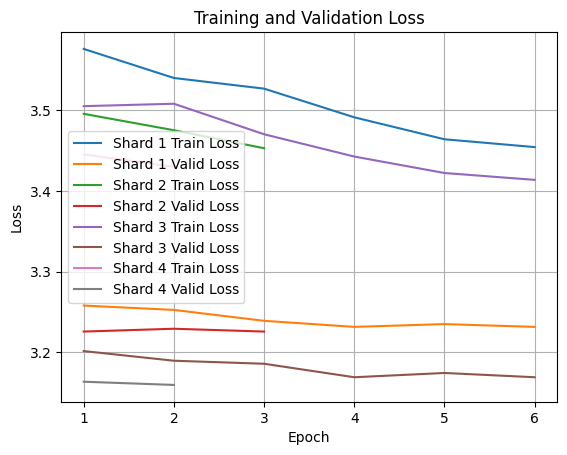

In [ ]:
import matplotlib.pyplot as plt

# 各シャードのトレーニングロスとバリデーションロスを格納するリスト
training_losses = []
validation_losses = []

# histories からロスを取り出す
for history in histories:
    train_loss = [x['loss'] for x in history if 'loss' in x]
    valid_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

validation_losses = [loss[1:] for loss in validation_losses]

# プロット
epochs = range(1, len(training_losses[0]) + 1)
for i in range(len(training_losses)):
    # epochs と training_losses[i] の長さを比較し、短い方に合わせる
    min_length = min(len(epochs), len(training_losses[i]))
    plt.plot(epochs[:min_length], training_losses[i][:min_length], label=f'Shard {i+1} Train Loss')

    # epochs と validation_losses[i] の長さを比較し、短い方に合わせる
    min_length = min(len(epochs), len(validation_losses[i]))
    plt.plot(epochs[:min_length], validation_losses[i][:min_length], label=f'Shard {i+1} Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mv ./results drive/MyDrive/nlp_dataset/models

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoConfig

model_name = "/content/drive/MyDrive/nlp_dataset/models/yuukimotai_roberta-finetuned-squad_20240808/checkpoint-2650"
config = AutoConfig.from_pretrained(model_name, attention_probs_dropout_prob=0.3)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, config=config).to(device)

In [ ]:
model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [ ]:
trainer.save_model("/content/drive/MyDrive/nlp_dataset/models/roberta-finetuned-20240811")

In [ ]:
!pip3 install boto3

In [ ]:
import boto3

# S3 クライアントを作成
s3 = boto3.client('s3')

# アップロードするファイルのパス
file_path = base_path + 'yuukimotai_roberta-finetuned-squad_20240814/checkpoint-2650/'

# S3 バケット名とファイル名
bucket_name = 'yuukimotai-transformers-model-checkpoints'
object_name = 'finetuned20240814'

# ファイルをアップロード
s3.put_object(Bucket=bucket_name, Key=object_name)  #ディレクトリ作成
for file in os.listdir(file_path):
    s3.upload_file(file_path + file, bucket_name, object_name)

In [ ]:
import boto3
s3 = boto3.client('s3')
s3.download_file('yuukimotai-transformers-model-checkpoints', 'finetuned20240814.zip', 'finetuned20240814.zip')

In [ ]:
import zipfile
with zipfile.ZipFile('finetuned20240814.zip', 'r') as zip_ref:
    zip_ref.extractall('.')